In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
collection_name = 'week22_lipschitz_son'
collection = seml.database.get_collection(collection_name)

In [5]:
by_status = defaultdict(set)
for r in collection.find():
    by_status[r['status']].add(r['config']['data']['dataset'])

In [6]:
by_status

defaultdict(set,
            {'COMPLETED': {'amazon_photo', 'citeseer', 'cora_full'},
             'FAILED': {'citeseer'}})

In [7]:
collection_name = 'week22_lipschitz_son'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [8]:
# experiments_killed = [r for r in collection.find() if r['status'] in ('KILLED',)]

In [9]:
# experiments_failed = [r for r in collection.find() if r['status'] in ('FAILED',)]
# [ex['fail_trace'] for ex in experiments_failed]
# set(e['config']['data']['dataset'] for e in experiments_killed)

In [10]:
keys = set()
for ex in experiments:
    keys |= set(ex['metrics'].keys())

list(keys)

['misclassification_auroc_feature-distance_loc_fit-95conf-no-edges_test',
 'misclassification_auroc_gpc-iso-mode:weighted-relative:True:no_loc_fit-95conf_val',
 'ood_auroc_gpc-iso-mode:max-relative:True:no_loc_fit-95conf-no-edges_test',
 'ood_auroc_gpc-diag-mode:weighted-relative:True:no_ber_fit-95conf_test',
 'misclassification_auroc_gpc-iso-mode:weighted-relative:False:no_normal_fit-95conf-no-edges_val',
 'misclassification_auroc_gpc-diag-mode:max-relative:False:no_ber_fit-mask-no-edges_val',
 'ood_auroc_feature-distance_ber_fit-95conf_test',
 'ood_auroc_gpc-eye-mode:weighted-relative:False:no_loc_fit-95conf-no-edges_test',
 'ood_auroc_gpc-eye-mode:max-relative:True:no_normal_fit-mask_val',
 'misclassification_auroc_gpc-iso-mode:max-relative:False:no_loc_fit-95conf_test',
 'ood_aucpr_gpc-full-mode:max-relative:True:no_ber_fit-95conf-no-edges_val',
 'misclassification_aucpr_gpc-iso-mode:weighted-relative:False:no_ber_fit-95conf_val',
 'ood_auroc_gpc-iso-mode:max-relative:False:no_norm

In [11]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
PROXY = 'Proxy'
EXPERIMENT = 'Experiment'
DATASET = 'Dataset'
PERTURBATION = 'Perturbations'

RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Norm'
SPECTRAL_OUTPUT_NORM = 'Spectral Norm on Last Layer'
WEIGHT_SCALE = 'Weight Scale'
LOWER_LIPSCHITZ = 'Empirical Lower\nLipschitz Bound'
UPPER_LIPSCHITZ = 'Empirical Upper\nLipschitz Bound'

OOD_TYPE = 'O.O.D. Type'

EPISTEMIC = 'Epistemic'
ALEATORIC = 'Aleatoric'

ACCURACY = 'Accuracy'
# ECE = 'Expected Calibration Error'
ECE = 'ECE'

In [12]:
mode = 'test'

In [13]:
ex['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'residual': True,
 'use_bias': True,
 'use_spectral_norm': True,
 'use_spectral_norm_on_last_layer': True,
 'weight_scale': 50.0}

In [14]:
[k for k in ex['metrics'].keys() if 'no-edges' in k and 'auroc' in k]

['ood_auroc_total-predictive-entropy_ber-no-edges_val',
 'misclassification_auroc_total-predictive-entropy_ber-no-edges_val',
 'ood_auroc_max-score_ber-no-edges_val',
 'misclassification_auroc_max-score_ber-no-edges_val',
 'ood_auroc_logit-energy_ber-no-edges_val',
 'misclassification_auroc_logit-energy_ber-no-edges_val',
 'ood_auroc_gpc-full-mode:weighted-relative:False:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:weighted-relative:False:no_ber_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:weighted-relative:True:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:weighted-relative:True:no_ber_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:max-relative:False:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:max-relative:False:no_ber_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:max-relative:True:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:max-relative:True:no_ber_fit-mask-no-edges_va

In [15]:
# epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-95conf'
aleatoric_proxy = 'ood_max-score'
epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-mask'
# metric = 'auroc'
# METRIC = 'AUC-ROC'
metric = 'auroc'
METRIC = 'AUC-ROC'

In [16]:
Counter(ex['config']['model']['use_spectral_norm_on_last_layer'] for ex in experiments)

Counter({False: 3238, True: 3024})

In [17]:
data_proxy, data_acc_ece = [], []

unrecognized = set()

for ex in experiments:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        RESIDUAL : cfg['model']['residual'],
        SPECTRAL_NORM :  cfg['model']['use_spectral_norm'],
        WEIGHT_SCALE : cfg['model']['weight_scale'],
        # SPECTRAL_OUTPUT_NORM : {True : 'Output Norm.', False : 'No Ouput Norm.'}[cfg['model']['use_spectral_norm_on_last_layer']],
        SPECTRAL_OUTPUT_NORM : cfg['model']['use_spectral_norm_on_last_layer'],
        OOD_TYPE : {dc.LEFT_OUT_CLASSES : LOC, dc.PERTURBATION : PERTURBATION}[cfg['data']['ood_type']],
        DATASET :  cfg['data']['dataset'],
        LOWER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_min_perturbation_noise_{mode}'][0]['value'],
        UPPER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_max_perturbation_noise_{mode}'][0]['value'],
    }
    data_acc_ece.append(base | {
        ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
        ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
    })
    for k, vs in ex['metrics'].items():
        if metric in k and k.endswith('_' + mode):
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == aleatoric_proxy:
                metric_cfg[PROXY] = ALEATORIC
            elif k == epistemic_proxy:
                metric_cfg[PROXY] = EPISTEMIC
            else:
                unrecognized.add(k)
                continue
            
            for v in vs:
                v = v['value']
                data_proxy.append({
                    METRIC : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base | {
                    ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
                    ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
                }
                )
                

In [18]:
list(unrecognized)

['ood_gpc-full-mode:max-relative:True:no_fit-95conf',
 'ood_gpc-eye-mode:max-relative:False:no_fit-mask',
 'misclassification_gpc-eye-mode:weighted-relative:False:no_fit-mask',
 'misclassification_gpc-full-mode:max-relative:True:no_fit-mask',
 'ood_gpc-diag-mode:max-relative:True:no_fit-mask',
 'misclassification_gpc-diag-mode:max-relative:True:no_fit-95conf',
 'misclassification_gpc-eye-mode:max-relative:True:no_fit-95conf',
 'misclassification_gpc-iso-mode:max-relative:True:no_fit-mask',
 'ood_gpc-eye-mode:max-relative:False:no_fit-95conf',
 'ood_gpc-iso-mode:weighted-relative:True:no_fit-95conf',
 'misclassification_gpc-diag-mode:max-relative:False:no_fit-mask',
 'ood_gpc-diag-mode:max-relative:True:no_fit-95conf',
 'misclassification_gpc-iso-mode:max-relative:False:no_fit-95conf',
 'ood_feature-distance_fit-mask',
 'ood_logit-energy',
 'misclassification_gpc-full-mode:weighted-relative:False:no_fit-mask',
 'ood_gpc-eye-mode:weighted-relative:True:no_fit-95conf',
 'misclassification

In [19]:
df_proxy = pd.DataFrame(data_proxy)
df_acc_ece = pd.DataFrame(data_acc_ece)

In [20]:
df_proxy[
    (df_proxy[EXPERIMENT] == LOC) &
    (df_proxy[NO_EDGES] == False) &
    (df_proxy[SETTING] == HYBRID) &
    (df_proxy[PROXY] == EPISTEMIC) &
    (df_proxy[SPECTRAL_NORM] == True)
]

,AUC-ROC,No Edges,Experiment,Proxy,Setting,Residual,Spectral Norm,Weight Scale,Spectral Norm on Last Layer,O.O.D. Type,Dataset,Empirical Lower\nLipschitz Bound,Empirical Upper\nLipschitz Bound,Accuracy,ECE
219,0.673529,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,False,Leave Out Classes,cora_full,0.000598,0.058972,0.315789,0.165085
223,0.702435,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,False,Leave Out Classes,cora_full,0.000771,0.061731,0.259414,0.108720
227,0.662410,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,False,Leave Out Classes,cora_full,0.000552,0.061141,0.265010,0.109195
231,0.470948,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,False,Leave Out Classes,cora_full,0.000725,0.071773,0.658947,0.501022
235,0.457748,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,False,Leave Out Classes,cora_full,0.000575,0.082739,0.550209,0.391844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29215,0.613967,False,Leave Out Classes,Epistemic,Inductive,True,True,50.0,True,Leave Out Classes,citeseer,1.065374,16.913559,0.711111,0.276155
29219,0.586735,False,Leave Out Classes,Epistemic,Inductive,True,True,50.0,True,Leave Out Classes,citeseer,1.960247,21.037691,0.622222,0.355330
29223,0.705628,False,Leave Out Classes,Epistemic,Inductive,True,True,50.0,True,Leave Out Classes,citeseer,1.039581,15.543317,0.711864,0.280454
29227,0.646934,False,Leave Out Classes,Epistemic,Inductive,True,True,50.0,True,Leave Out Classes,citeseer,1.043871,18.304203,0.677778,0.311400


In [21]:
set(df_proxy[OOD_TYPE])

{'Leave Out Classes', 'Perturbations'}

(<Figure size 504x252 with 20 Axes>,
 array([[<AxesSubplot:title={'center':'Leave Out Classes'}, ylabel='AUC-ROC'>,
         <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'Bernoulli'}>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:title={'center':'Normal'}>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='Weight Scale', ylabel='AUC-ROC'>,
         <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='Weight Scale'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:xlabel='Weight Scale'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

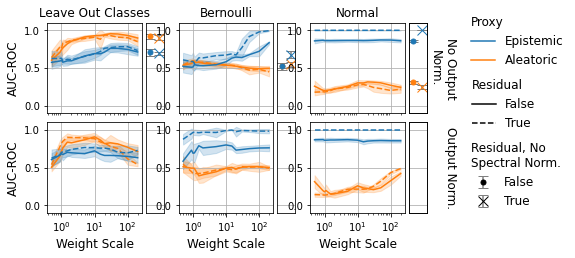

In [24]:

def plot_facet_grid_with_proxy_hue(data, x, y, log_x=True, binned=False):
                                    
    fig, axs = plt.subplots(2, 9, figsize=(7, 3.5), gridspec_kw = {
            'width_ratios' : [0.8, 0.15, 0.06] * 3, 'wspace' : 0.1, 'hspace' : 0.1,
    }, sharey=False)
    
    baseline_axs = axs[:, 1::3]
    proxy_axs = axs[:, 0::3]
    invisible_axs = axs[:, 2::3]
    
    for col_idx, col in enumerate((LOC, BERNOULLI, NORMAL)):
        for row_idx, row in enumerate((False, True)):
            ax = proxy_axs[row_idx, col_idx]
            if col_idx == 0:
                # ax.set_ylabel({True : 'No Output\nNorm.', False : 'Ouput Norm.'}[row])
                ax.set_ylabel(y, fontsize=12)
                tax = baseline_axs[row_idx, -1].twinx()
                tax.set_ylabel({False : 'No Output\nNorm.', True : 'Output Norm.'}[row], fontsize=12, rotation=270, 
                               labelpad=30)
                tax.tick_params(axis='y', labelright=False, right=False)
                
                
            if row_idx == axs.shape[0] - 1:
                ax.set_xlabel(x, fontsize=12)
            elif row_idx == 0:
                ax.set_title(col)
            
            
            for proxy, color in ((ALEATORIC, 'tab:orange'), (EPISTEMIC, 'tab:blue')):
                for residual, linestyle, markerstyle in ((False, '-', '.'), (True, '--', 'x')):

                    data_rc = data[(data[EXPERIMENT] == col) & (data[SPECTRAL_OUTPUT_NORM] == row) 
                                   & (data[PROXY] == proxy) & (data[RESIDUAL] == residual)]
                    data_rc_proxy = data_rc[(data_rc[SPECTRAL_NORM] == True)]
                    data_rc_baseline = data_rc[(data_rc[SPECTRAL_NORM] == False)]

                    x_rc_proxy, y_rc_proxy = data_rc_proxy[x].to_numpy(), data_rc_proxy[y].to_numpy()
                    if log_x: # Convert to log space to calculate binning in
                        x_rc_proxy = np.log(x_rc_proxy)
                    if binned:
                        bin_centers = np.linspace(x_rc_proxy.min(), x_rc_proxy.max(), 25)
                    else:
                        bin_centers = np.array(sorted(np.unique(x_rc_proxy)))

                    bin_idx = np.abs(x_rc_proxy[:, None] - bin_centers[None, :]).argmin(1)
                    means = np.array([y_rc_proxy[bin_idx == idx].mean() for idx in range(bin_centers.shape[0])])
                    stds = np.array([y_rc_proxy[bin_idx == idx].std() for idx in range(bin_centers.shape[0])])
                    
                    
                    if log_x: # Revert to normal space
                        bin_centers = np.exp(bin_centers)
                        ax.set_xscale('log')
                    
                    ax.plot(bin_centers, means, color=color, linestyle=linestyle)
                    ax.fill_between(bin_centers, means - stds, means + stds, alpha = .2, color=color)
            
                    # Baseline proxy
                    y_baseline = data_rc_baseline[y].to_numpy()
                    if y_baseline.shape[0] > 0:
                        baseline_axs[row_idx, col_idx].errorbar([int(residual)], [y_baseline.mean()], yerr=[y_baseline.std()], ecolor='gray', capsize=5, fmt=markerstyle, color=color, ms=10)
                    else:
                        baseline_axs[row_idx, col_idx].tick_params(axis='x', bottom=False, labelbottom=False)
                        baseline_axs[row_idx, col_idx].tick_params(axis='y', left=False, labelleft=False)
            
            y_min, y_max = ax.get_ylim()
            y_min_bl, y_max_bl = baseline_axs[row_idx, col_idx].get_ylim()
            ax.set_ylim(min(y_min, y_min_bl), max(y_max, y_max_bl))
            baseline_axs[row_idx, col_idx].set_ylim(min(y_min, y_min_bl), max(y_max, y_max_bl))
                
    
    # Configure axis
    for ax in axs[:, 1::3].flatten():
        ax.tick_params(axis='y', labelleft=False, left=False)
    for ax in invisible_axs.flatten():
        ax.set_visible(False)
    for ax in axs[:-1, :].flatten():
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
    for ax in baseline_axs.flatten():
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
        ax.set_xlim(-0.5, 1.5)
    for ax in proxy_axs.flatten():
        ax.grid(which='major')
    for ax in baseline_axs[:, :].flatten():
        ax.grid(which='major', axis='y')
    for ax in axs.flatten():
        ax.set_ylim(-0.1, 1.1)
        
    # Build legends
    handles = []
    handles += axs[-1, -1].plot([], [], color='tab:blue')
    handles += axs[-1, -1].plot([], [], color='tab:orange')
    legend_proxy = fig.legend(handles, [EPISTEMIC, ALEATORIC], title=PROXY, bbox_to_anchor=(1.17, 0.95), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_proxy.get_title(),fontsize=12)
    legend_proxy._legend_box.align = "left"
    
    handles = []
    handles += axs[-1, -1].plot([], [], color='black', ls='-')
    handles += axs[-1, -1].plot([], [], color='black', ls='--')
    legend_residual = fig.legend(handles, [False, True], title=RESIDUAL, bbox_to_anchor=(1.115, 0.7), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_residual.get_title(),fontsize=12)
    legend_residual._legend_box.align = "left"
    
    handles = []
    handles += [axs[-1, -1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='.', color='black', ms=10)]
    handles += [axs[-1, -1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='x', color='black', ms=10)]
    legend_baseline = fig.legend(handles, [False, True], title='Residual, No\nSpectral Norm.', bbox_to_anchor=(1.165, 0.45), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_baseline.get_title(),fontsize=12)
    legend_baseline._legend_box.align = "left"
    
    axs[-1, -1].add_artist(legend_proxy)
    axs[-1, -1].add_artist(legend_residual)
    
    return fig, axs

plot_facet_grid_with_proxy_hue(df_proxy[(df_proxy[NO_EDGES] == False) & (df_proxy[SETTING] == HYBRID) & (df_proxy[DATASET] == dc.CORA_FULL)], WEIGHT_SCALE, METRIC, log_x=True) 


(<Figure size 504x252 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'Leave Out Classes'}, ylabel='Accuracy'>,
         <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'Perturbations'}>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='Weight Scale', ylabel='ECE'>,
         <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='Weight Scale'>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

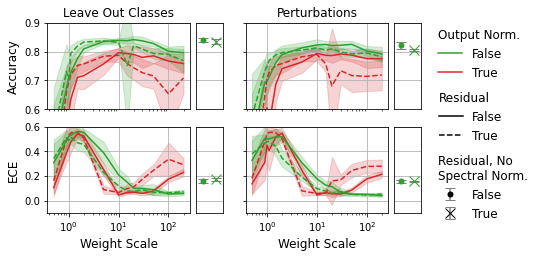

In [25]:
def plot_facet_grid_multiple_metrics(data, x, ys, log_x=True, binned=False, y_limits={
    ACCURACY : (0.6, 0.9),
    ECE : (-0.1, 0.6),
}):
                                    
    fig, axs = plt.subplots(len(ys), 6, figsize=(7, 3.5), gridspec_kw = {
            'width_ratios' : [0.8, 0.15, 0.06] * 2, 'wspace' : 0.1, 'hspace' : 0.2,
    }, sharey='row')
    
    baseline_axs = axs[:, 1::3]
    proxy_axs = axs[:, 0::3]
    invisible_axs = axs[:, 2::3]
    
    for col_idx, col in enumerate((LOC, PERTURBATION)):
        for row_idx, y in enumerate(ys):
            ax = proxy_axs[row_idx, col_idx]
            if col_idx == 0:
                # ax.set_ylabel({True : 'No Output\nNorm.', False : 'Ouput Norm.'}[row])
                ax.set_ylabel(y, fontsize=12)
                #tax = baseline_axs[row_idx, -1].twinx()
                #tax.set_ylabel({False : 'No Output Norm.', True : 'Output Norm.'}[row], fontsize=12, rotation=270, 
                #               labelpad=18)
                #tax.tick_params(axis='y', labelright=False, right=False)
                
                
            if row_idx == axs.shape[0] - 1:
                ax.set_xlabel(x, fontsize=12)
            elif row_idx == 0:
                ax.set_title(col)
            
            
            for use_son, color in ((True, 'tab:red'), (False, 'tab:green')):
                for residual, linestyle, markerstyle in ((False, '-', '.'), (True, '--', 'x')):

                    data_rc = data[(data[OOD_TYPE] == col) & (data[SPECTRAL_OUTPUT_NORM] == use_son) 
                                    & (data[RESIDUAL] == residual)]
                    
                    data_rc_proxy = data_rc[(data_rc[SPECTRAL_NORM] == True)]
                    data_rc_baseline = data_rc[(data_rc[SPECTRAL_NORM] == False)]

                    x_rc_proxy, y_rc_proxy = data_rc_proxy[x].to_numpy(), data_rc_proxy[y].to_numpy()
                    if log_x: # Convert to log space to calculate binning in
                        x_rc_proxy = np.log(x_rc_proxy)
                    if binned:
                        bin_centers = np.linspace(x_rc_proxy.min(), x_rc_proxy.max(), 25)
                    else:
                        bin_centers = np.array(sorted(np.unique(x_rc_proxy)))

                    bin_idx = np.abs(x_rc_proxy[:, None] - bin_centers[None, :]).argmin(1)
                    means = np.array([y_rc_proxy[bin_idx == idx].mean() for idx in range(bin_centers.shape[0])])
                    stds = np.array([y_rc_proxy[bin_idx == idx].std() for idx in range(bin_centers.shape[0])])
                    
                    
                    if log_x: # Revert to normal space
                        bin_centers = np.exp(bin_centers)
                        ax.set_xscale('log')
                    
                    ax.plot(bin_centers, means, color=color, linestyle=linestyle)
                    ax.fill_between(bin_centers, means - stds, means + stds, alpha = .2, color=color)
            
                    # Baseline proxy
                    y_baseline = data_rc_baseline[y].to_numpy()
                    if y_baseline.shape[0] > 0:
                        baseline_axs[row_idx, col_idx].errorbar([int(residual)], [y_baseline.mean()], yerr=[y_baseline.std()], ecolor='gray', capsize=5, fmt=markerstyle, color=color, ms=10)
                    else:
                        baseline_axs[row_idx, col_idx].tick_params(axis='x', bottom=False, labelbottom=False)
                        baseline_axs[row_idx, col_idx].tick_params(axis='y', left=False, labelleft=False)
                
    
    # Configure axis
    for ax in axs[:, 1::3].flatten():
        ax.tick_params(axis='y', labelleft=False, left=False)
    for ax in invisible_axs.flatten():
        ax.set_visible(False)
    for ax in axs[:-1, :].flatten():
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
    for ax in baseline_axs.flatten():
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
        ax.set_xlim(-0.5, 1.5)
    for ax in proxy_axs.flatten():
        ax.grid(which='major')
    for ax in baseline_axs[:, :].flatten():
        ax.grid(which='major', axis='y')
    for ax, y in zip(axs[:, 0].flatten(), ys):
        if y in y_limits:
            ax.set_ylim(*(y_limits[y]))
      
    # Build legends
    handles = []
    handles += axs[-1, -1].plot([], [], color='tab:green')
    handles += axs[-1, -1].plot([], [], color='tab:red')
    legend_proxy = fig.legend(handles, [False, True], title='Output Norm.', bbox_to_anchor=(1.085, 0.9), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_proxy.get_title(),fontsize=12)
    legend_proxy._legend_box.align = "left"
    
    
    handles = []
    handles += axs[-1, -1].plot([], [], color='black', ls='-')
    handles += axs[-1, -1].plot([], [], color='black', ls='--')
    legend_residual = fig.legend(handles, [False, True], title=RESIDUAL, bbox_to_anchor=(1.05, 0.65), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_residual.get_title(),fontsize=12)
    legend_residual._legend_box.align = "left"
    
    handles = []
    handles += [axs[-1, -1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='.', color='black', ms=10)]
    handles += [axs[-1, -1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='x', color='black', ms=10)]
    legend_baseline = fig.legend(handles, [False, True], title='Residual, No\nSpectral Norm.', bbox_to_anchor=(1.10, 0.4), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_baseline.get_title(),fontsize=12)
    legend_baseline._legend_box.align = "left"
    
    axs[-1, -1].add_artist(legend_proxy)
    axs[-1, -1].add_artist(legend_residual)
    
    return fig, axs

plot_facet_grid_multiple_metrics(df_proxy[(df_proxy[SETTING] == HYBRID) & (df_proxy[DATASET] == dc.CORA_FULL)], WEIGHT_SCALE, [ACCURACY, ECE], log_x=True) 

<ipython-input-35-617ee41c172d>:34: RuntimeWarning: Mean of empty slice.
  means = np.array([y_rc_proxy[bin_idx == idx].mean() for idx in range(bin_centers.shape[0])])
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-35-617ee41c172d>:34: Run

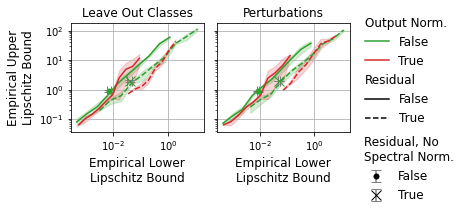

In [35]:
def plot_xy_with_unnormalized_x( data, x, y, log_x=True, binned=True, bins=10):                      
    fig, axs = plt.subplots(1, 2, figsize=(5, 2.), gridspec_kw = {
        'wspace' : 0.1, 'hspace' : 0.1,
    }, sharey='row')
    
    for col_idx, col in enumerate((LOC, PERTURBATION)):
        ax = axs[col_idx]
        if col_idx == 0:
            # ax.set_ylabel({True : 'No Output\nNorm.', False : 'Ouput Norm.'}[row])
            ax.set_ylabel(y, fontsize=12)

        ax.set_xlabel(x, fontsize=12)
        ax.set_title(col)

        for use_son, color in ((False, 'tab:green'), (True, 'tab:red')):
            for residual, linestyle, markerstyle in ((False, '-', '.'), (True, '--', 'x')):

                data_rc = data[(data[OOD_TYPE] == col) & (data[SPECTRAL_OUTPUT_NORM] == use_son) 
                               & (data[RESIDUAL] == residual)]
                data_rc_proxy = data_rc[(data_rc[SPECTRAL_NORM] == True)]
                data_rc_baseline = data_rc[(data_rc[SPECTRAL_NORM] == False)]

                x_rc_proxy, y_rc_proxy = data_rc_proxy[x].to_numpy(), data_rc_proxy[y].to_numpy()
                x_rc_baseline, y_rc_baseline = data_rc_baseline[x].to_numpy(), data_rc_baseline[y].to_numpy()

                if log_x: # Convert to log space to calculate binning in
                    x_rc_proxy = np.log(x_rc_proxy)
                if binned:
                    bin_centers = np.linspace(x_rc_proxy.min(), x_rc_proxy.max(), bins)
                else:
                    bin_centers = np.array(sorted(np.unique(x_rc_proxy)))

                bin_idx = np.abs(x_rc_proxy[:, None] - bin_centers[None, :]).argmin(1)
                means = np.array([y_rc_proxy[bin_idx == idx].mean() for idx in range(bin_centers.shape[0])])
                stds = np.array([y_rc_proxy[bin_idx == idx].std() for idx in range(bin_centers.shape[0])])


                if log_x: # Revert to normal space
                    bin_centers = np.exp(bin_centers)
                    ax.set_xscale('log')

                ax.plot(bin_centers, means, color=color, linestyle=linestyle)
                ax.fill_between(bin_centers, means - stds, means + stds, alpha = .2, color=color)

                # Baseline proxy
                if y_rc_baseline.shape[0] > 0:
                    ax.errorbar([x_rc_baseline.mean()], [y_rc_baseline.mean()], yerr=[y_rc_baseline.std()], xerr = [x_rc_baseline.std()],
                                ecolor='gray', capsize=5, fmt=markerstyle, color=color, ms=10)
                    
    for ax in axs.flatten():
        ax.grid(which='major')
        
    # Build legends
    handles = []
    handles += axs.flatten()[-1].plot([], [], color='tab:green')
    handles += axs.flatten()[-1].plot([], [], color='tab:red')
    legend_proxy = fig.legend(handles, [False, True], title='Output Norm.', bbox_to_anchor=(1.2, 1.0), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_proxy.get_title(),fontsize=12)
    legend_proxy._legend_box.align = "left"
    
    
    handles = []
    handles += axs.flatten()[-1].plot([], [], color='black', ls='-')
    handles += axs.flatten()[-1].plot([], [], color='black', ls='--')
    legend_residual = fig.legend(handles, [False, True], title=RESIDUAL, bbox_to_anchor=(1.15, 0.6), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_residual.get_title(),fontsize=12)
    legend_residual._legend_box.align = "left"
    
    handles = []
    handles += [axs.flatten()[-1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='.', color='black', ms=10)]
    handles += [axs.flatten()[-1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='x', color='black', ms=10)]
    legend_baseline = fig.legend(handles, [False, True], title='Residual, No\nSpectral Norm.', bbox_to_anchor=(1.22, 0.17), loc='upper right', frameon=False, fontsize=12)
    plt.setp(legend_baseline.get_title(),fontsize=12)
    legend_baseline._legend_box.align = "left"
    for artist in handles:
        artist.remove()
    
    #axs.flatten()[-1].add_artist(legend_proxy)
    #axs.flatten()[-1].add_artist(legend_residual)
    
    return fig, axs
    
fig, axs = plot_xy_with_unnormalized_x(df_proxy[(df_proxy[SETTING] == HYBRID) 
                            & (df_proxy[DATASET] == dc.CORA_FULL)
        ], LOWER_LIPSCHITZ, UPPER_LIPSCHITZ)

for ax in axs.flatten():
    ax.set_yscale('log')



## Save an array of plots for different settings and datasets

thesis_nbs/spectral_norm_plots/cora_full-inductive-auroc-Weight-Scale-no-edges.pdf
thesis_nbs/spectral_norm_plots/citeseer-inductive-auroc-Weight-Scale-no-edges.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-inductive-auroc-Weight-Scale-no-edges.pdf
thesis_nbs/spectral_norm_plots/cora_full-transductive-auroc-Weight-Scale-no-edges.pdf
thesis_nbs/spectral_norm_plots/citeseer-transductive-auroc-Weight-Scale-no-edges.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-transductive-auroc-Weight-Scale-no-edges.pdf
thesis_nbs/spectral_norm_plots/cora_full-inductive-auroc-Weight-Scale.pdf
thesis_nbs/spectral_norm_plots/citeseer-inductive-auroc-Weight-Scale.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-inductive-auroc-Weight-Scale.pdf
thesis_nbs/spectral_norm_plots/cora_full-transductive-auroc-Weight-Scale.pdf
thesis_nbs/spectral_norm_plots/citeseer-transductive-auroc-Weight-Scale.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-transductive-auroc-Weight-Scale.pdf


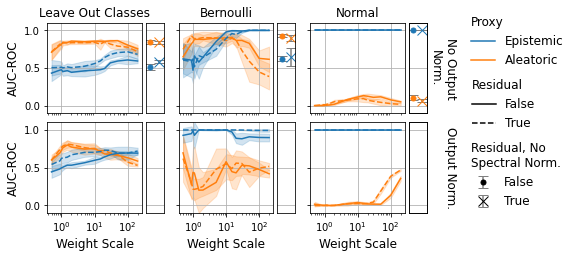

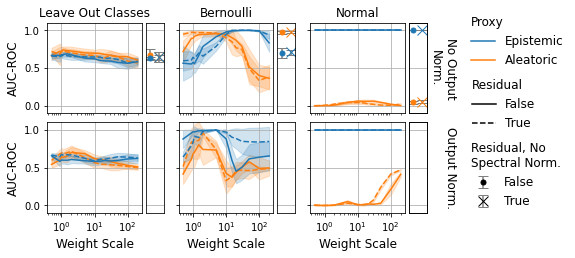

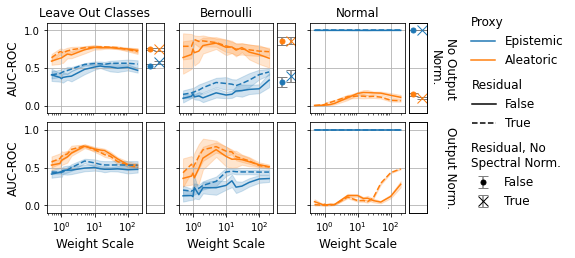

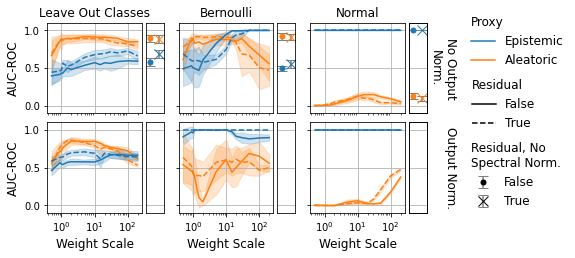

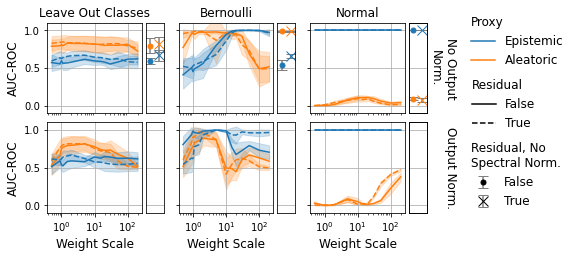

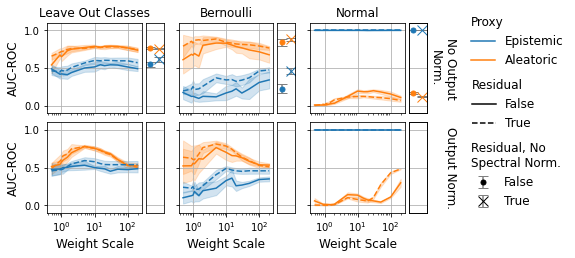

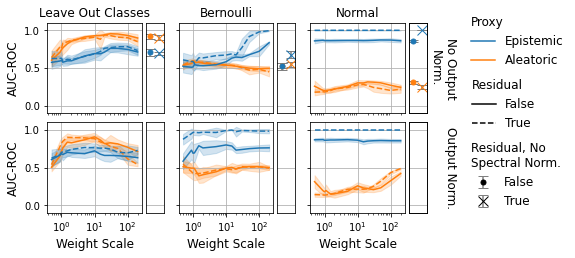

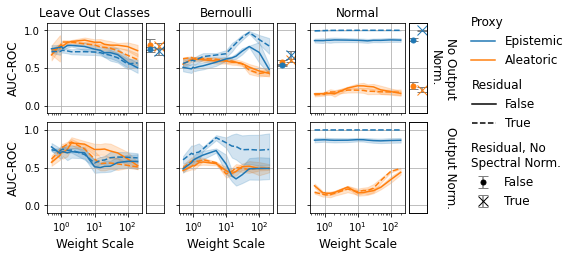

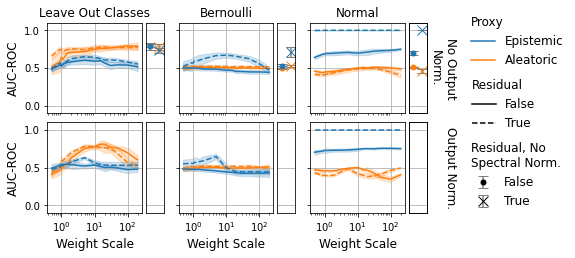

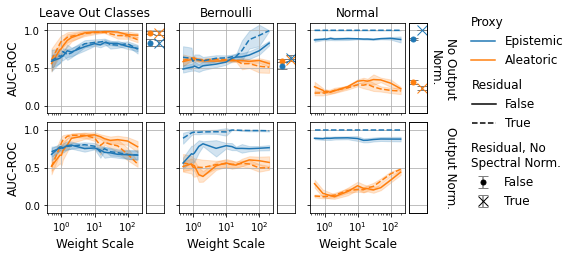

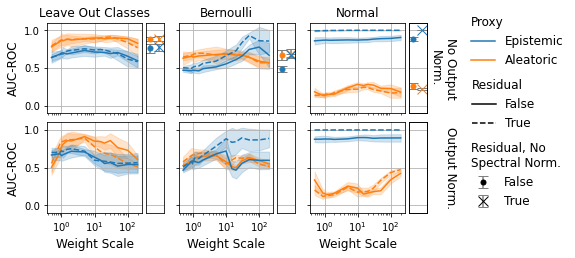

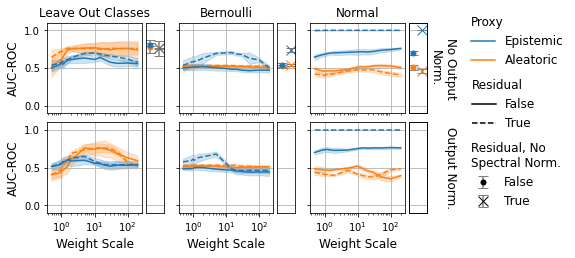

In [28]:
for no_edges, fn_suffix in ((True, '-no-edges'), (False, '')):
    for setting in (HYBRID, TRANSDUCTIVE):
        for dataset in (dc.CORA_FULL, dc.CITESEER, dc.AMAZON_PHOTO):
            
            fig, axs = plot_facet_grid_with_proxy_hue(
                df_proxy[
                    (df_proxy[NO_EDGES] == no_edges) 
                    & (df_proxy[SETTING] == setting) 
                    & (df_proxy[DATASET] == dataset)
                ], WEIGHT_SCALE, METRIC, log_x=True) 
        
            x_fn = WEIGHT_SCALE.replace(' ','-')
            path = f'thesis_nbs/spectral_norm_plots/{dataset}-{setting.lower()}-{metric.lower()}-{x_fn}{fn_suffix}.pdf'
            fig.savefig(path, bbox_inches='tight')
            print(path)

thesis_nbs/spectral_norm_plots/cora_full-inductive-Weight-Scale-accuracy-ece.pdf
thesis_nbs/spectral_norm_plots/citeseer-inductive-Weight-Scale-accuracy-ece.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-inductive-Weight-Scale-accuracy-ece.pdf
thesis_nbs/spectral_norm_plots/cora_full-transductive-Weight-Scale-accuracy-ece.pdf
thesis_nbs/spectral_norm_plots/citeseer-transductive-Weight-Scale-accuracy-ece.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-transductive-Weight-Scale-accuracy-ece.pdf


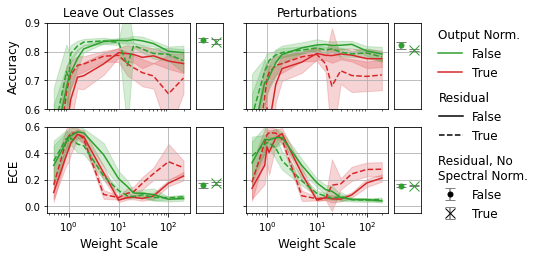

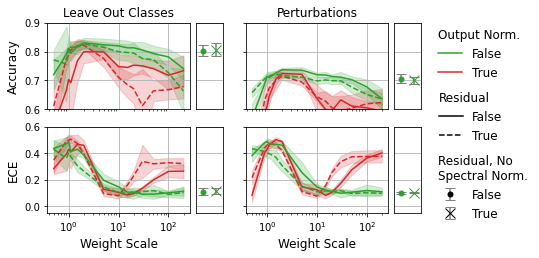

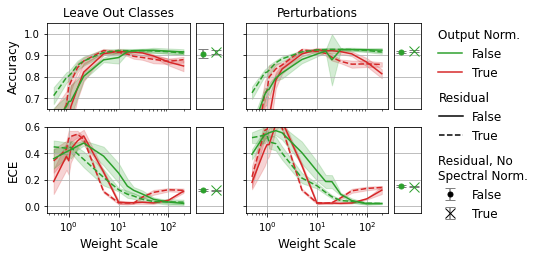

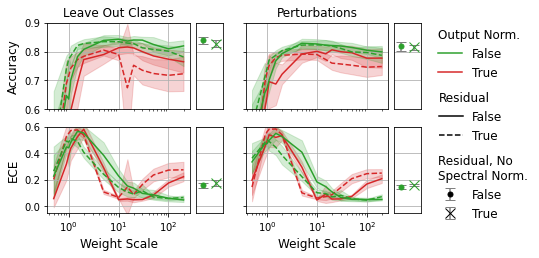

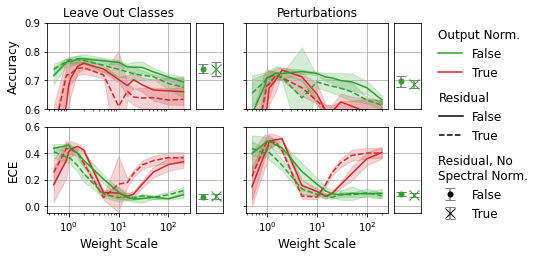

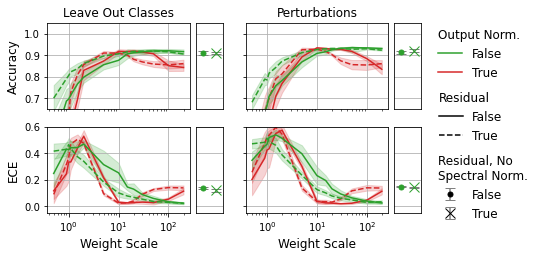

In [29]:

for setting in (HYBRID, TRANSDUCTIVE):
    for dataset in (dc.CORA_FULL, dc.CITESEER, dc.AMAZON_PHOTO):
        ys = [ACCURACY, ECE]
        if dataset == dc.CORA_FULL:
            y_limits = {ACCURACY : (0.6, 0.9), ECE : (-0.05, 0.6),}
        elif dataset == dc.CITESEER:
            y_limits = {ACCURACY : (0.6, 0.9), ECE : (-0.05, 0.6),}
        elif dataset == dc.AMAZON_PHOTO:
            y_limits = {ACCURACY : (0.65, 1.05), ECE : (-0.05, 0.6),}
        else:
            y_limits = {}
            
        fig, axs = plot_facet_grid_multiple_metrics(
            df_proxy[
                (df_proxy[SETTING] == setting) 
                & (df_proxy[DATASET] == dataset)
            ], WEIGHT_SCALE, ys, log_x=True, y_limits=y_limits,
        )
        
        
        x_fn = WEIGHT_SCALE.replace(' ','-')
        y_fn = '-'.join(map(lambda s: s.replace(' ', '-').lower(), ys))
        path = f'thesis_nbs/spectral_norm_plots/{dataset}-{setting.lower()}-{x_fn}-{y_fn}.pdf'
        fig.savefig(path, bbox_inches='tight')
        print(path)

thesis_nbs/spectral_norm_plots/cora_full-inductive-Weight-Scale-empirical-lower-lipschitz-bound-empirical-upper-lipschitz-bound.pdf
thesis_nbs/spectral_norm_plots/citeseer-inductive-Weight-Scale-empirical-lower-lipschitz-bound-empirical-upper-lipschitz-bound.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-inductive-Weight-Scale-empirical-lower-lipschitz-bound-empirical-upper-lipschitz-bound.pdf
thesis_nbs/spectral_norm_plots/cora_full-transductive-Weight-Scale-empirical-lower-lipschitz-bound-empirical-upper-lipschitz-bound.pdf
thesis_nbs/spectral_norm_plots/citeseer-transductive-Weight-Scale-empirical-lower-lipschitz-bound-empirical-upper-lipschitz-bound.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-transductive-Weight-Scale-empirical-lower-lipschitz-bound-empirical-upper-lipschitz-bound.pdf


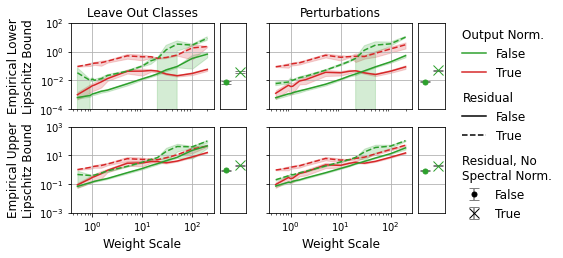

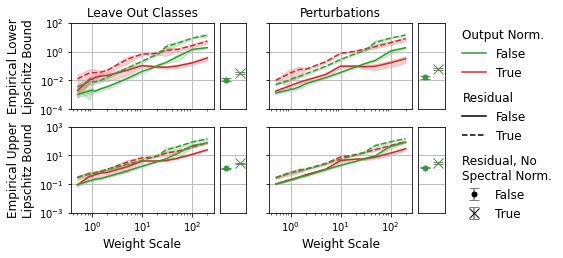

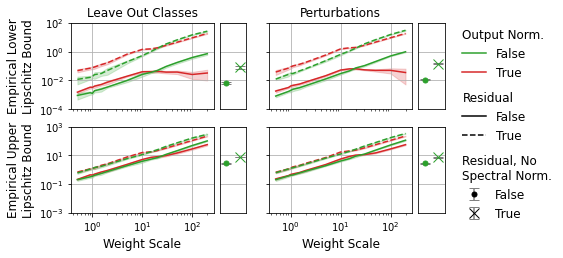

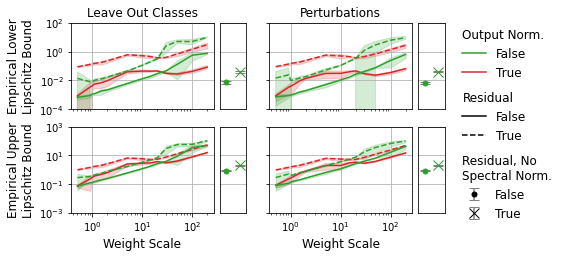

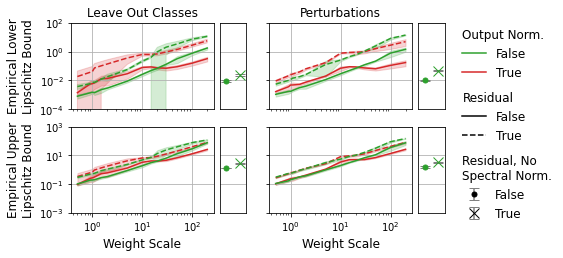

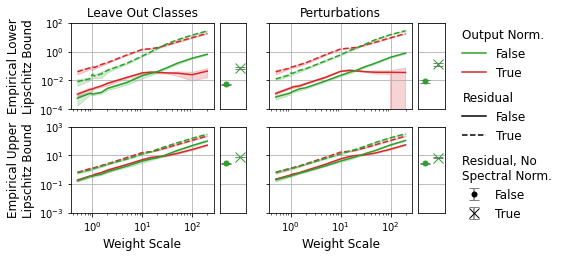

In [30]:

for setting in (HYBRID, TRANSDUCTIVE):
    for dataset in (dc.CORA_FULL, dc.CITESEER, dc.AMAZON_PHOTO):
        ys = [LOWER_LIPSCHITZ, UPPER_LIPSCHITZ]
        fig, axs = plot_facet_grid_multiple_metrics(
            df_proxy[
                (df_proxy[SETTING] == setting) 
                & (df_proxy[DATASET] == dataset)], 
            WEIGHT_SCALE, ys, log_x=True, y_limits={
                LOWER_LIPSCHITZ : (1e-4, 1e2),
                UPPER_LIPSCHITZ : (1e-3, 1e3),
            })

        for ax in axs.flatten():
            ax.set_yscale('log')
        
        x_fn = WEIGHT_SCALE.replace(' ','-')
        y_fn = '-'.join(map(lambda s: s.replace(' ', '-').replace('\n', '-').lower(), ys))
        path = f'thesis_nbs/spectral_norm_plots/{dataset}-{setting.lower()}-{x_fn}-{y_fn}.pdf'
        fig.savefig(path, bbox_inches='tight')
        print(path)
            

<ipython-input-35-617ee41c172d>:34: RuntimeWarning: Mean of empty slice.
  means = np.array([y_rc_proxy[bin_idx == idx].mean() for idx in range(bin_centers.shape[0])])
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-35-617ee41c172d>:34: Run

thesis_nbs/spectral_norm_plots/cora_full-inductive-Empirical-Lower-Lipschitz-Bound-Empirical-Upper-Lipschitz-Bound.pdf
thesis_nbs/spectral_norm_plots/citeseer-inductive-Empirical-Lower-Lipschitz-Bound-Empirical-Upper-Lipschitz-Bound.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-inductive-Empirical-Lower-Lipschitz-Bound-Empirical-Upper-Lipschitz-Bound.pdf
thesis_nbs/spectral_norm_plots/cora_full-transductive-Empirical-Lower-Lipschitz-Bound-Empirical-Upper-Lipschitz-Bound.pdf
thesis_nbs/spectral_norm_plots/citeseer-transductive-Empirical-Lower-Lipschitz-Bound-Empirical-Upper-Lipschitz-Bound.pdf
thesis_nbs/spectral_norm_plots/amazon_photo-transductive-Empirical-Lower-Lipschitz-Bound-Empirical-Upper-Lipschitz-Bound.pdf


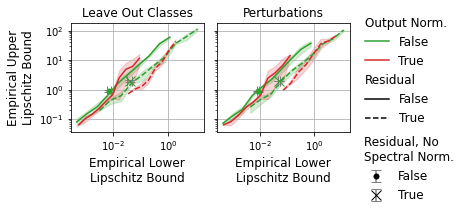

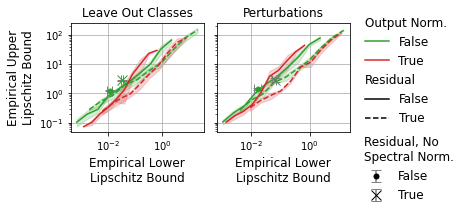

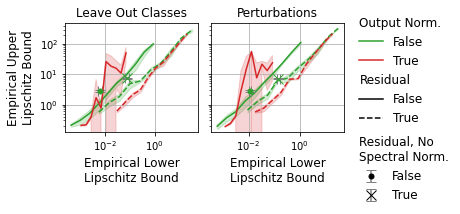

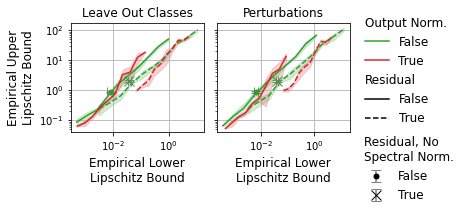

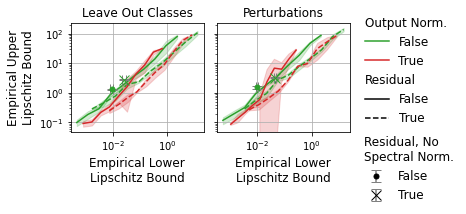

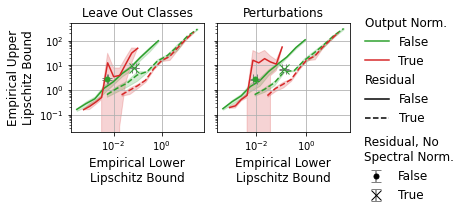

In [36]:

for setting in (HYBRID, TRANSDUCTIVE):
    for dataset in (dc.CORA_FULL, dc.CITESEER, dc.AMAZON_PHOTO):

        fig, axs = plot_xy_with_unnormalized_x(df_proxy[(df_proxy[SETTING] == setting) 
                            & (df_proxy[DATASET] == dataset)
        ], LOWER_LIPSCHITZ, UPPER_LIPSCHITZ)

        for ax in axs.flatten():
            ax.set_yscale('log')
        
        x_fn = LOWER_LIPSCHITZ.replace(' ','-').replace('\n', '-')
        y_fn = UPPER_LIPSCHITZ.replace(' ','-').replace('\n', '-')
        path = f'thesis_nbs/spectral_norm_plots/{dataset}-{setting.lower()}-{x_fn}-{y_fn}.pdf'
        fig.savefig(path, bbox_inches='tight')
        print(path)
